In [1]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm; tqdm.pandas()
pd.options.display.max_columns = 202
pd.options.display.max_rows = 300
import seaborn as sns

In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]

train.drop(special_cols[0], axis=1, inplace=True)
test.drop(special_cols[0], axis=1, inplace=True)

unique_samples = []
unique_count = np.zeros_like(test)
for feature in tqdm(range(test.shape[1])):
    _, index_, count_ = np.unique(test.values[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

fake_test=test.iloc[synthetic_samples_indexes].reset_index(drop=True)
test=test.iloc[real_samples_indexes].reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 33.55it/s]


In [3]:
target_corr = [train[[f, 'target']].corr('spearman').loc[f, 'target'] for f in tqdm(feature_cols)]

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.59it/s]


In [4]:
train_target_corr_sum = train[feature_cols].progress_apply(lambda row: np.dot(row.values, target_corr), axis=1)
test_target_corr_sum = test[feature_cols].progress_apply(lambda row: np.dot(row.values, target_corr), axis=1)

100%|███████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31220.73it/s]


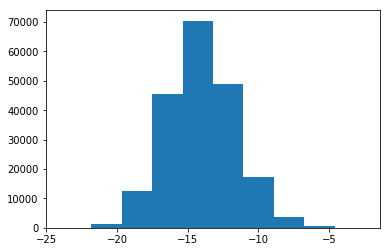

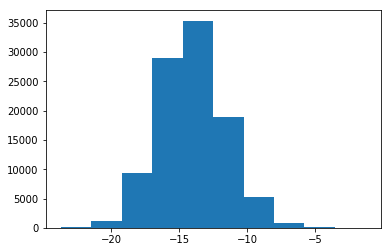

In [6]:
plt.hist(train_target_corr_sum); plt.show(); 
plt.hist(test_target_corr_sum); plt.show()

In [7]:
train['train_target_corr_sum'] = train_target_corr_sum
test['train_target_corr_sum'] = test_target_corr_sum
train[['target', 'train_target_corr_sum']].corr('spearman')

,target,train_target_corr_sum
target,1.00000,0.32163
train_target_corr_sum,0.32163,1.00000


In [8]:
train[['train_target_corr_sum']].to_pickle('features/target_corr_sum_train.pkl')
test[['train_target_corr_sum']].to_pickle('features/target_corr_sum_test.pkl')